<a href="https://colab.research.google.com/github/HyeonhoonLee/TSA_pandas/blob/master/08_ETS_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETS Decomposition


- ETS 컴포넌트들을 시각화하는 것은 데이터의 흐름을 이해하는데 큰 도움이 됩니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AG7Tlk4iqOz7oEU17tJnaX1OEHzKkhIyZx3EZxYE0s8lxWQVuBTk9Y
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Additive Model

$y_t = Level(Cyclical) + Trend + Seasonality + Noise(Error)$

- 그런데, Level은 decomposition할 수 없어서 Noise로 들어간다.

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# 임의로 noise섞인 상향 trend를 만들어서 공부해보자.
# [i for i in range(1,100)] -> 이렇게만해도 1부터 99까지의 상향 트렌드가 만들어짐.
series = pd.Series([i+np.random.randint(10) for i in range(1,100)])

# seasonal_decompose함수는 model 기본이 'additive'인데 명시적으로 아래 인수에 입력함.
# 기본 list형태가 함수 인자에 들어가면 freq=1을 따로 입력하지 않아도됨.
# 여기서는 pd.series 형태로 하였기 때문에 freq=1을 입력함.
result = seasonal_decompose(series, model='additive', freq=1)

In [7]:
## 알고 싶은 component를 .뒤에 입력하면된다.
result.trend

0       3.0
1       4.0
2       6.0
3       5.0
4       5.0
      ...  
94    103.0
95     97.0
96    101.0
97     98.0
98    100.0
Length: 99, dtype: float64

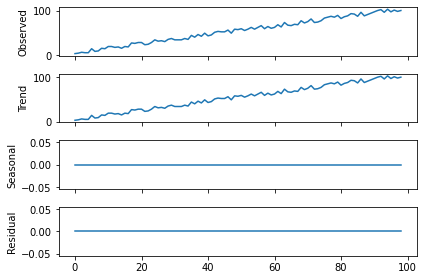

In [11]:
# 간략하게 시각화하고 싶다면,
result.plot();

In [12]:
# 위의 plot을 길이를 늘린다든지 handling을 하고싶다면 함수를 생성.
def plot_decompose(decomposeresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
    decomposeresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observerd')
    decomposeresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposeresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposeresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('Resid')

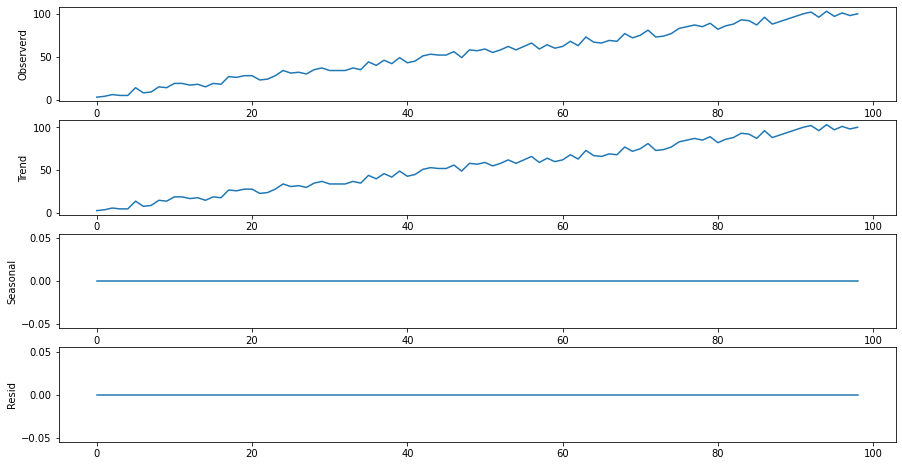

In [13]:
plot_decompose(result)

### Multiplicative Model

$y_t = Level \times Trend \times Seasonality \times Noise$

- data가 exponential한 모습을 보이면 이러한 모델을 사용
- 사실 좌변에 log만 씌워주면 additive model과 같음.

In [14]:
series = pd.Series([i**2 for i in range(1,100)])

result = seasonal_decompose(series, model='multiplicative', freq=1)

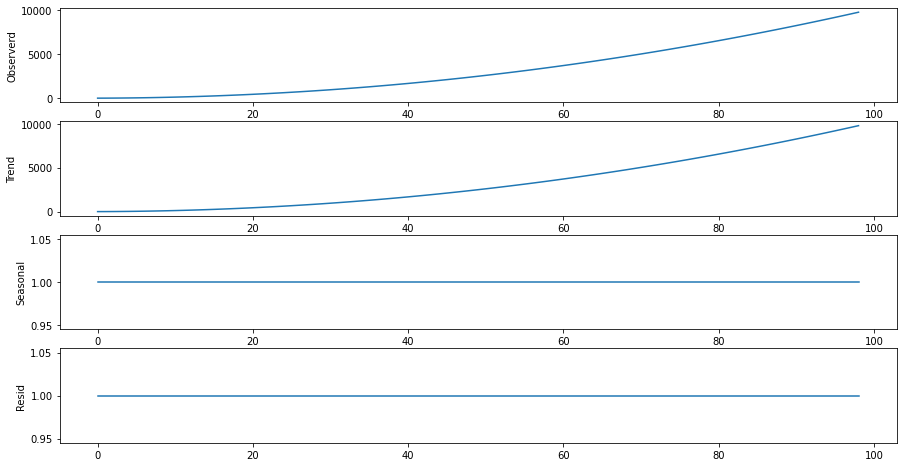

In [15]:
plot_decompose(result)

In [17]:
airline = pd.read_csv('/content/drive/My Drive/Tacademy/TSA_pandas/data/airline_passengers.csv', index_col='Month')

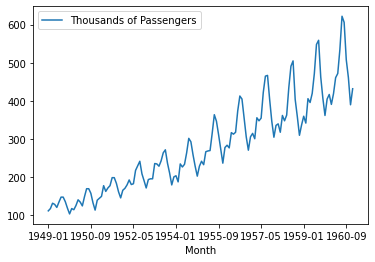

In [18]:
airline.plot()

## ETS

linear trend 를 가지고 있고 seasonality 와 trend 컴포넌트가 시간흐름에 따라 고정적일 때 (ex 매년 승객 1만명 증가) additive model 을 사용합니다. non-linear 하게 증가하거나 감소하는 trend 를 보일 경우 (ex 매년 승객 수 두 배 증가) multiplicative model 이 더 적합합니다.

챠트를 보면 초기에 비해 후기로 갈 수록 꾸준히 증가하는 비율로 비선형 증가 추세를 보이고 있습니다.

In [19]:
airline.index = pd.to_datetime(airline.index)

In [20]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [21]:
result = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative')

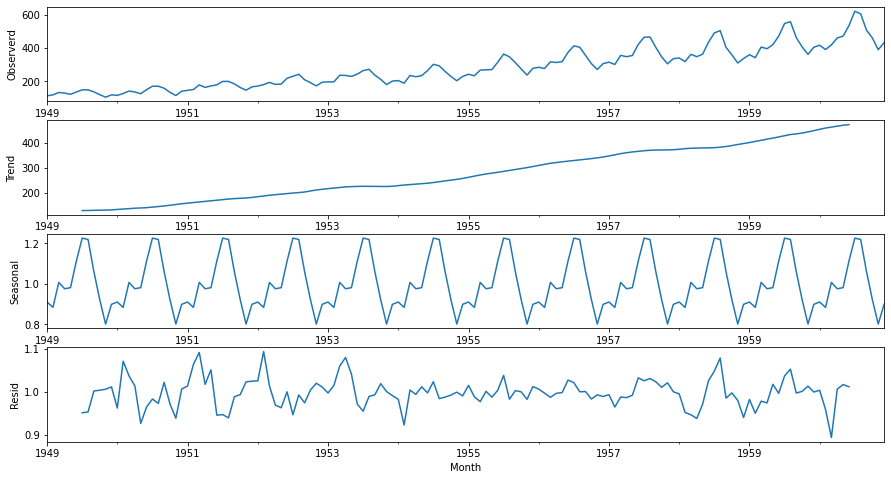

In [22]:
plot_decompose(result)

In [22]:
# 시계열 데이터를 분석하고 모델링한다는 것은 Trend를 제거하고 Seasonality를 뺀 다음에,
# noise(residual)에서 패턴을 찾아서 모델링한 다음에, 
# 다시 predicition할 때는 모델링한거에다가 Seasonality를 더해주고 Trend를 더하는 방식으로
# prediction을 한다.